# 1. Import Required Lib

In [1]:
import pandas as pd
import numpy as np
import unicodedata
import string
import re
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle
import random
import pdb
from torch.utils.data import DataLoader
import logging
import itertools
import unicodedata
import string
import re
import random
import argparse
from torch import optim
import time
import os
from bleu_score import BLEU_SCORE
# from models_viet import EncoderRNN, AttentionDecoderRNN, DecoderRNN
from load_dataset_viet import *
# from define_training_viet import *
import torchtext
from torch.utils.data import BatchSampler
from torch.utils.data import SequentialSampler
from torch.utils.data import Sampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
%matplotlib inline
import math
import copy
import seaborn

In [2]:
device = torch.device('cuda')

# 2. Build data loaders

In [3]:
class Vietnamese(Dataset):
    def __init__(self, df, val = False):
        self.df = df
        self.val = val
        
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        english = self.df.iloc[idx,:]['en_idized']
        viet = self.df.iloc[idx,:]['vi_idized']
        en_len = self.df.iloc[idx,:]['en_len']
        vi_len = self.df.iloc[idx,:]['vi_len']
        if self.val:
            en_data = self.df.iloc[idx,:]['en_data'].lower()
            return [viet,english,vi_len,en_len,en_data]
        else:
            return [viet,english,vi_len,en_len]
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
def vocab_collate_func(batch):
    MAX_LEN_EN = 48
    MAX_LEN_VI = 48
    en_data = []
    vi_data = []
    en_len = []
    vi_len = []
    for datum in batch:
        en_len.append(datum[3])
        vi_len.append(datum[2])
    max_batch_length_en = max(en_len)
    max_batch_length_vi = max(vi_len)
    if max_batch_length_en < MAX_LEN_EN:
        MAX_LEN_EN = max_batch_length_en
    if max_batch_length_vi < MAX_LEN_VI:
        MAX_LEN_VI = max_batch_length_vi
    # padding
    for datum in batch:
        if datum[2]>MAX_LEN_VI:
            padded_vec_s1 = np.array(datum[0])[:MAX_LEN_VI]
        else:
            padded_vec_s1 = np.pad(np.array(datum[0]),
                                pad_width=((0,MAX_LEN_VI - datum[2])),
                                mode="constant", constant_values=PAD_IDX)
        if datum[3]>MAX_LEN_EN:
            padded_vec_s2 = np.array(datum[1])[:MAX_LEN_EN]
        else:
            padded_vec_s2 = np.pad(np.array(datum[1]),
                                pad_width=((0,MAX_LEN_EN - datum[3])),
                                mode="constant", constant_values=PAD_IDX)
        en_data.append(padded_vec_s2)
        vi_data.append(padded_vec_s1)
    vi_data = np.array(vi_data)
    en_data = np.array(en_data)
    vi_len = np.array(vi_len)
    en_len = np.array(en_len)
#     sorted_vi_len = np.argsort(-vi_len)
#     vi_data = vi_data[sorted_vi_len]
#     en_data = en_data[sorted_vi_len]
#     vi_len = vi_len[sorted_vi_len]
#     en_len = en_len[sorted_vi_len]
#     print(en_len)
    vi_len[vi_len>MAX_LEN_VI] = MAX_LEN_VI
    en_len[en_len>MAX_LEN_EN] = MAX_LEN_EN
        
    return [torch.from_numpy(vi_data), torch.from_numpy(en_data),
            torch.from_numpy(vi_len), torch.from_numpy(en_len)]

def convert_idx_2_sent(tensor, lang_obj):
    word_list = []
    for i in tensor:
        if i.item() not in set([PAD_IDX,EOS_token,SOS_token]):
            word_list.append(lang_obj.index2word[i.item()])
    return (' ').join(word_list)

def convert_id_list_2_sent(list_idx, lang_obj):
    word_list = []
    if type(list_idx) == list:
        for i in list_idx:
            if i not in set([EOS_token]):
                word_list.append(lang_obj.index2word[i])
    else:
        for i in list_idx:
            if i.item() not in set([EOS_token,SOS_token,PAD_IDX]):
                word_list.append(lang_obj.index2word[i.item()])
    return (' ').join(word_list)

In [4]:
def vocab_collate_func_val(batch):
    return [torch.from_numpy(np.array(batch[0][0])).unsqueeze(0), torch.from_numpy(np.array(batch[0][1])).unsqueeze(0),
            torch.from_numpy(np.array(batch[0][2])).unsqueeze(0), torch.from_numpy(np.array(batch[0][3])).unsqueeze(0),batch[0][4]]

In [5]:
# MAX_LEN = 48
train,val,test,en_lang,vi_lang = train_val_load(48, "", '/scratch/ark576/machine_translation_data/')

In [6]:
def shuffle_sorted_batches(train, bs):
    batch_samp_list = list(BatchSampler(SequentialSampler(train), bs, drop_last = False))
    np.random.shuffle(batch_samp_list)
    batch_samp_list_merged = list(itertools.chain(*batch_samp_list))
    return train.iloc[batch_samp_list_merged,:]

In [7]:
train.head()

,en_data,vi_data,en_tokenized,vi_tokenized,en_idized,vi_idized,en_len,vi_len
0,Rachel Pike : The science behind a climate hea...,Khoa_học đằng_sau một tiêu_đề về khí_hậu,"[rachel, pike, :, the, science, behind, a, cli...","[khoa_học, đằng_sau, một, tiêu_đề, về, khí_hậu]","[8225, 2, 137, 4, 150, 573, 9, 15, 3717, 1]","[7, 1433, 5, 3054, 4, 13, 1]",10,7
1,"In 4 minutes , atmospheric chemist Rachel Pike...","Trong 4 phút , chuyên_gia hoá_học khí_quyển Ra...","[in, 4, minutes, ,, atmospheric, chemist, rach...","[trong, 4, phút, ,, chuyên_gia, hoá_học, khí_q...","[12, 5080, 264, 7, 20, 4552, 8225, 2, 3006, 9,...","[23, 812, 253, 8, 1043, 1342, 20, 8510, 2, 161...",51,57
2,I &apos;d like to talk to you today about the ...,Tôi muốn cho các bạn biết về sự to_lớn của nhữ...,"[i, &apos;d, like, to, talk, to, you, today, a...","[tôi, muốn, cho, các, bạn, biết, về, sự, to_lớ...","[23, 247, 16, 13, 272, 13, 33, 273, 100, 4, 14...","[26, 152, 47, 11, 38, 149, 4, 92, 787, 9, 15, ...",28,26
3,Headlines that look like this when they have t...,Có những dòng trông như thế_này khi bàn về biế...,"[headlines, that, look, like, this, when, they...","[có, những, dòng, trông, như, thế_này, khi, bà...","[6, 11, 24, 16, 21, 49, 35, 31, 13, 36, 51, 15...","[21, 15, 530, 419, 17, 193, 34, 488, 4, 1227, ...",32,25
4,They are both two branches of the same field o...,Cả hai đều là một nhánh của cùng một lĩnh_vực ...,"[they, are, both, two, branches, of, the, same...","[cả, hai, đều, là, một, nhánh, của, cùng, một,...","[35, 55, 402, 118, 3364, 5, 4, 154, 260, 5, 20...","[41, 273, 70, 16, 5, 3618, 9, 178, 5, 198, 23,...",14,16


In [8]:
bs_dict = {'train':128,'validate':1, 'train_val':1,'val_train':128, 'test':1}
shuffle_dict = {'train':True,'validate':False, 'train_val':False,'val_train':True, 'test':False}
# train_used = shuffle_sorted_batches(train_sorted, bs_dict['train'])
# train_used = train.iloc[:50]
train_used = train
val_used = val
# val_used = val.iloc[:20]
collate_fn_dict = {'train':vocab_collate_func, 'validate':vocab_collate_func_val,\
                   'train_val':vocab_collate_func_val,'val_train':vocab_collate_func,'test': vocab_collate_func_val}
transformed_dataset = {'train': Vietnamese(train_used),
                       'validate': Vietnamese(val_used, val = True),
                       'train_val':Vietnamese(train.iloc[:50], val = True),
                       'val_train':Vietnamese(val_used),
                       'test':Vietnamese(test, val= True)
                                               }

dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs_dict[x], collate_fn=collate_fn_dict[x],
                    shuffle=shuffle_dict[x], num_workers=0) for x in ['train', 'validate', 'train_val','val_train', 'test']}

# 3. Build Models

In [2]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, embed_dim, hidden_size,n_layers, rnn_type = 'lstm', device = 'cuda'):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = Embedding(input_size, embed_dim, PAD_IDX)
        self.rnn_type =  rnn_type
        self.dropout_in = nn.Dropout(p = 0.1)
        self.n_layers = n_layers
        self.device = device
        if rnn_type == 'gru':
            self.rnn = nn.GRU(embed_dim, hidden_size,batch_first=True,bidirectional=True, num_layers = self.n_layers, dropout = 0.2)
        elif rnn_type == 'lstm':
            self.rnn = LSTM(embed_dim, hidden_size, batch_first=True,bidirectional=True, num_layers = n_layers,dropout = 0.2)

    def forward(self, enc_inp, src_len):
        sorted_idx = torch.sort(src_len, descending=True)[1]
        orig_idx = torch.sort(sorted_idx)[1]
        embedded = self.embedding(enc_inp)
        bs = embedded.size(0)
        output = self.dropout_in(embedded)
        if self.rnn_type == 'gru':
            hidden =  self.initHidden(bs)
            sorted_output = output[sorted_idx]
            sorted_len = src_len[sorted_idx]
            packed_output = nn.utils.rnn.pack_padded_sequence(sorted_output, sorted_len.data.tolist(), batch_first = True)
            packed_outs, hiddden = self.rnn(packed_output,(hidden, c))
            hidden = hidden[:,orig_idx,:]
            output, _ = nn.utils.rnn.pad_packed_sequence(packed_outs, padding_value=PAD_IDX, batch_first = True)
            output = output[orig_idx]
            hidden = hidden.view(self.n_layers, 2, bs, -1).transpose(1, 2).contiguous().view(self.n_layers, bs, -1)
            return output, hidden, hidden
        elif self.rnn_type == 'lstm':
            hidden, c = self.initHidden(bs)
            sorted_output = output[sorted_idx]
            sorted_len = src_len[sorted_idx]
            packed_output = nn.utils.rnn.pack_padded_sequence(sorted_output, sorted_len.data.tolist(), batch_first = True)
            packed_outs, (hiddden, c) = self.rnn(packed_output,(hidden, c))
            hidden = hidden[:,orig_idx,:]
            c = c[:,orig_idx,:]
            output, _ = nn.utils.rnn.pad_packed_sequence(packed_outs, padding_value=PAD_IDX, batch_first = True)
            output = output[orig_idx]
            c = c.view(self.n_layers, 2, bs, -1).transpose(1, 2).contiguous().view(self.n_layers, bs, -1)
            hidden = hidden.view(self.n_layers, 2, bs, -1).transpose(1, 2).contiguous().view(self.n_layers, bs, -1)
            return output, hidden, c
        
    def initHidden(self,bs):
        if self.rnn_type == 'gru' :
            return torch.zeros(self.n_layers*2, bs, self.hidden_size).to(self.device)
        elif self.rnn_type == 'lstm':
            return torch.zeros(self.n_layers*2,bs,self.hidden_size).to(self.device),torch.zeros(self.n_layers*2,bs,self.hidden_size).to(self.device)

class Attention_Module(nn.Module):
    def __init__(self, hidden_dim, output_dim, device = 'cuda'):
        super(Attention_Module, self).__init__()
        self.l1 = Linear(hidden_dim, output_dim, bias = False)
        self.l2 = Linear(hidden_dim+output_dim, output_dim, bias =  False)
        self.device = device
        
    def forward(self, hidden, encoder_outs, src_lens):
        ''' hiddden: bsz x hidden_dim
        encoder_outs: bsz x sq_len x encoder dim (output_dim)
        src_lens: bsz
        
        x: bsz x output_dim
        attn_score: bsz x sq_len'''
        x = self.l1(hidden)
        att_score = (encoder_outs.transpose(0,1) * x.unsqueeze(0)).sum(dim = 2)
        seq_mask = sequence_mask(src_lens, max_len = max(src_lens).item(), device = self.device).transpose(0,1)
        masked_att = seq_mask*att_score
        masked_att[masked_att==0] = -1e10
        attn_scores = F.softmax(masked_att, dim=0)
        x = (attn_scores.unsqueeze(2) * encoder_outs.transpose(0,1)).sum(dim=0)
        x = torch.tanh(self.l2(torch.cat((x, hidden), dim=1)))
        return x, attn_scores
        
class AttentionDecoderRNN(nn.Module):
    def __init__(self, output_size, embed_dim, hidden_size, n_layers = 1, attention = True, device = 'cuda'):
        super(AttentionDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        encoder_output_size = hidden_size
        self.embedding = Embedding(output_size, embed_dim, PAD_IDX)
        self.dropout = nn.Dropout(p=0.1)
        self.n_layers = n_layers
        self.device = device
        self.att_layer = Attention_Module(self.hidden_size, encoder_output_size,self.device) if attention else None
        self.layers = nn.ModuleList([
            LSTMCell(
                input_size=self.hidden_size + embed_dim if ((layer == 0) and attention) else embed_dim if layer == 0 else hidden_size,
                hidden_size=hidden_size,
            )
            for layer in range(self.n_layers)
        ])
        self.fc_out = nn.Linear(self.hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, dec_input,context_vector, prev_hiddens,prev_cs,encoder_outputs,src_len):
        bsz = dec_input.size(0)
        output = self.embedding(dec_input)
        output = self.dropout(output)
        if self.att_layer is not None:
            cated_input = torch.cat([output.squeeze(1),context_vector], dim = 1)
        else:
            cated_input = output.squeeze(1)
        new_hiddens = []
        new_cs = []
        for i, rnn in enumerate(self.layers):
            hidden, c = rnn(cated_input, (prev_hiddens[i], prev_cs[i]))
            cated_input = self.dropout(hidden)
            new_hiddens.append(hidden.unsqueeze(0))
            new_cs.append(c.unsqueeze(0))
        new_hiddens = torch.cat(new_hiddens, dim = 0)
        new_cs = torch.cat(new_cs, dim = 0)

        # apply attention using the last layer's hidden state
        if self.att_layer is not None:
            out, attn_score = self.att_layer(hidden, encoder_outputs, src_len)
        else:
            out = hidden
            attn_score = None
        context_vec = out
        out = self.dropout(out)
        out_vocab = self.softmax(self.fc_out(out))

        return out_vocab, context_vec, new_hiddens, new_cs, attn_score

# 4. Utilites functions, training and evaluation functions 

In [18]:
def Embedding(num_embeddings, embedding_dim, padding_idx):
    m = nn.Embedding(num_embeddings, embedding_dim, padding_idx=padding_idx)
    nn.init.uniform_(m.weight, -0.1, 0.1)
    nn.init.constant_(m.weight[padding_idx], 0)
    return m


def LSTM(input_size, hidden_size, **kwargs):
    m = nn.LSTM(input_size, hidden_size,**kwargs)
    for name, param in m.named_parameters():
        if 'weight' in name or 'bias' in name:
            param.data.uniform_(-0.1, 0.1)
    return m


def LSTMCell(input_size, hidden_size, **kwargs):
    m = nn.LSTMCell(input_size, hidden_size,**kwargs)
    for name, param in m.named_parameters():
        if 'weight' in name or 'bias' in name:
            param.data.uniform_(-0.1, 0.1)
    return m


def Linear(in_features, out_features, bias=True, dropout=0):
    """Linear layer (input: N x T x C)"""
    m = nn.Linear(in_features, out_features, bias=bias)
    m.weight.data.uniform_(-0.1, 0.1)
    if bias:
        m.bias.data.uniform_(-0.1, 0.1)
    return m

In [19]:
def sequence_mask(sequence_length, max_len=None, device = 'cuda'):
    if max_len is None:
        max_len = sequence_length.max().item()
    batch_size = sequence_length.size(0)
    seq_range = torch.arange(0, max_len).long()
    seq_range_expand = seq_range.unsqueeze(0).repeat([batch_size,1])
    seq_range_expand = seq_range_expand.to(device)
    seq_length_expand = (sequence_length.unsqueeze(1)
                         .expand_as(seq_range_expand))
    return (seq_range_expand < seq_length_expand).float()

In [22]:
def encode_decode(encoder,decoder,data_en,data_de,src_len,tar_len,rand_num = 0.95, val = False):
    if not val:
        use_teacher_forcing = True if random.random() < rand_num else False
    #     print("tar_len",tar_len)
        bss = data_en.size(0)
        en_out,en_hid,en_c = encoder(data_en, src_len)
        max_src_len_batch = max(src_len).item()
        max_tar_len_batch = max(tar_len).item()
        prev_hiddens = en_hid
        prev_cs = en_c
        decoder_input = torch.tensor([[SOS_token]]*bss).to(device)
        prev_output = torch.zeros((bss, en_out.size(-1))).to(device)
        if use_teacher_forcing:
            d_out = []
            for i in range(max_tar_len_batch):
                out_vocab, prev_output,prev_hiddens, prev_cs, attention_score = decoder(decoder_input,prev_output, \
                                                                                        prev_hiddens,prev_cs, en_out,\
                                                                                        src_len)
                d_out.append(out_vocab.unsqueeze(-1))
                decoder_input = data_de[:,i].view(-1,1)
            d_out = torch.cat(d_out,dim=-1)
        else:
            d_out = []
            for i in range(max_tar_len_batch):
                out_vocab, prev_output,prev_hiddens, prev_cs, attention_score = decoder(decoder_input,prev_output, \
                                                                                        prev_hiddens,prev_cs, en_out,\
                                                                                        src_len)
                d_out.append(out_vocab.unsqueeze(-1))
                topv, topi = out_vocab.topk(1)
                decoder_input = topi.squeeze().detach().view(-1,1)
            d_out = torch.cat(d_out,dim=-1)
        return d_out
    else:
        encoder.eval()
        decoder.eval()
        bss = data_en.size(0)
        en_out,en_hid,en_c = encoder(data_en, src_len)
        max_src_len_batch = max(src_len).item()
        max_tar_len_batch = max(tar_len).item()
        prev_hiddens = en_hid
        prev_cs = en_c
        decoder_input = torch.tensor([[SOS_token]]*bss).to(device)
        prev_output = torch.zeros((bss, en_out.size(-1))).to(device)
        d_out = []
        for i in range(max_tar_len_batch):
            out_vocab, prev_output,prev_hiddens, prev_cs, attention_score = decoder(decoder_input,prev_output, \
                                                                                    prev_hiddens,prev_cs, en_out,\
                                                                                    src_len)
            d_out.append(out_vocab.unsqueeze(-1))
            topv, topi = out_vocab.topk(1)
            decoder_input = topi.squeeze().detach().view(-1,1)
        d_out = torch.cat(d_out,dim=-1)
        return d_out

In [23]:
def flatten_cel_loss(input,target,nll):
    input = input.transpose(1,2)
    bs, sl = input.size()[:2]
    return nll(input.contiguous().view(bs*sl,-1),target.contiguous().view(-1))

In [24]:
def validation_new(encoder, decoder, val_dataloader, lang_en,lang_vi,m_type, verbose = False, replace_unk = False):
    encoder.eval()
    decoder.eval()
    pred_corpus = []
    true_corpus = []
    src_corpus = []
    running_loss = 0
    running_total = 0
    bl = BLEU_SCORE()
    attention_scores_for_all_val = []
    for data in val_dataloader:
        encoder_i = data[0].to(device)
        src_len = data[2].to(device)
        bs,sl = encoder_i.size()[:2]
        en_out,en_hid,en_c = encoder(encoder_i,src_len)
        max_src_len_batch = max(src_len).item()
        prev_hiddens = en_hid
        prev_cs = en_c
        decoder_input = torch.tensor([[SOS_token]]*bs).to(device)
        prev_output = torch.zeros((bs, en_out.size(-1))).to(device)
        d_out = []
        attention_scores = []
        for i in range(sl*2):
            out_vocab, prev_output,prev_hiddens, prev_cs, attention_score = decoder(decoder_input,prev_output, \
                                                                                    prev_hiddens,prev_cs, en_out,\
                                                                                    src_len)
            topv, topi = out_vocab.topk(1)
#             decoder_input = topi.squeeze().detach().view(-1,1)
            d_out.append(topi.item())
            decoder_input = topi.squeeze().detach().view(-1,1)
            if m_type == 'attention':
                attention_scores.append(attention_score.unsqueeze(-1))
            if topi.item() == EOS_token:
                break
        

#         true_sent = convert_id_list_2_sent(data[1][0],lang_en)
#         true_corpus.append(true_sent)
        if replace_unk:
            true_sent = convert_id_list_2_sent(data[1][0],lang_en)
            true_corpus.append(true_sent)
        else:
            true_corpus.append(data[-1])
        src_sent = convert_id_list_2_sent(data[0][0],lang_vi)
        src_corpus.append(src_sent)
        pred_sent = convert_id_list_2_sent(d_out,lang_en)
        pred_corpus.append(pred_sent)
        if m_type == 'attention':
            attention_scores = torch.cat(attention_scores, dim = -1)
            attention_scores_for_all_val.append(attention_scores)
        if verbose:
            print("True Sentence:",data[-1])
            print("Pred Sentence:", pred_sent)
            print('-*'*50)
    score = bl.corpus_bleu(pred_corpus,[true_corpus],lowercase=True)[0]
    return score, attention_scores_for_all_val, pred_corpus, src_corpus

In [25]:
def validation_beam_search(encoder, decoder, val_dataloader,lang_en,lang_vi,m_type, beam_size, verbose = False,\
                           device = 'cuda', replace_unk = False):
    encoder.eval()
    decoder.eval()
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    pred_corpus = []
    true_corpus = []
    src_corpus = []
    running_loss = 0
    running_total = 0
    bl = BLEU_SCORE()
    j = 0
    attention_scores_for_all_val = []
    for data in val_dataloader:
#         print(j)
        encoder_i = data[0].to(device)
        src_len = data[2].to(device)
        bs,sl = encoder_i.size()[:2]
        en_out,en_hid,en_c = encoder(encoder_i,src_len)
        max_src_len_batch = max(src_len).item()
        prev_hiddens = en_hid
        prev_cs = en_c
        decoder_input = torch.tensor([[SOS_token]]*bs).to(device)
        prev_output = torch.zeros((bs, en_out.size(-1))).to(device)
        list_decoder_input = [None]*beam_size
        beam_stop_flags = [False]*beam_size
        beam_score = torch.zeros((bs,beam_size)).to(device)
        list_d_outs = [[] for _ in range(beam_size)]
        select_beam_size = beam_size
        attention_scores = [[] for _ in range(beam_size)]
        for i in range(sl+20):
            if i == 0:
                out_vocab, prev_output,prev_hiddens, prev_cs, attention_score = decoder(decoder_input,prev_output, \
                                                                                    prev_hiddens,prev_cs, en_out,\
                                                                                    src_len)
                bss, vocab_size = out_vocab.size()
                topv, topi = out_vocab.topk(beam_size)
                list_prev_output = [prev_output]*beam_size
                list_prev_hiddens = [prev_hiddens]*beam_size
                list_prev_cs = [prev_cs]*beam_size
                for b in range(beam_size):
                    beam_score[0][b] = topv[0][b].item()
                    list_decoder_input[b] = topi[0][b].squeeze().detach().view(-1,1)
                    list_d_outs[b].append(topi[0][b].item())
                    if m_type == 'attention':
                        attention_scores[b].append(attention_score.unsqueeze(-1))
                    if topi[0][b].item() == EOS_token:
                        beam_stop_flags[b] = True
            else:
                beam_out_vocab = [None]*beam_size
                temp_out = [None]*beam_size
                temp_hid = [None]*beam_size
                temp_c = [None]*beam_size
                temp_attention_score = [[] for _ in range(beam_size)]
                prev_d_outs = copy.deepcopy(list_d_outs)
                for b in range(beam_size):
                    if not beam_stop_flags[b]:
                        beam_out_vocab[b], temp_out[b], temp_hid[b], temp_c[b], temp_attention_score[b] =\
                            decoder(list_decoder_input[b],list_prev_output[b],list_prev_hiddens[b],list_prev_cs[b],\
                                    en_out,src_len)
                        beam_out_vocab[b] = beam_out_vocab[b] + beam_score[0][b]
                    if beam_stop_flags[b]:
                        beam_out_vocab[b] = torch.zeros(bss,vocab_size).fill_(float('-inf')).to(device)
                beam_out_vocab = torch.cat(beam_out_vocab,dim = 1)
                
                topv, topi = beam_out_vocab.topk(beam_size)
                id_for_hid = topi//vocab_size
                topi_idx = topi%vocab_size
                for b in range(beam_size):
                    if not beam_stop_flags[b]:
                        beam_score[0][b] = topv[0][b].item()
                        list_decoder_input[b] = topi_idx[0][b].squeeze().detach().view(-1,1)
                        list_d_outs[b] = copy.deepcopy(prev_d_outs[id_for_hid[0][b]])
                        list_d_outs[b].append(topi_idx[0][b].item())
                        if m_type == 'attention':
                            attention_scores[b].append(temp_attention_score[b].unsqueeze(-1))
                        if topi_idx[0][b].item() == EOS_token:
                            beam_stop_flags[b] = True
                        else:
                            list_prev_output[b] = temp_out[id_for_hid[0][b]]
                            list_prev_hiddens[b] = temp_hid[id_for_hid[0][b]]
                            list_prev_cs[b] = temp_c[id_for_hid[0][b]]
                if all(beam_stop_flags):
                    break
        id_max_score = np.argmax(beam_score)
        d_out = list_d_outs[id_max_score]
        if m_type == 'attention':
            att_score = attention_scores[id_max_score]
            att_score = torch.cat(att_score, dim = -1)
            attention_scores_for_all_val.append(att_score)
        if replace_unk:
            true_sent = convert_id_list_2_sent(data[1][0],lang_en)
            true_corpus.append(true_sent)
        else:
            true_corpus.append(data[-1])
        pred_sent = convert_id_list_2_sent(d_out,lang_en)
        pred_corpus.append(pred_sent)
        src_sent = convert_id_list_2_sent(data[0][0], lang_vi)
        src_corpus.append(src_sent)
        if verbose:
            print("True Sentence:",data[-1])
            print("Pred Sentence:", pred_sent)
            print('-*'*50)
    score = bl.corpus_bleu(pred_corpus,[true_corpus],lowercase=True)[0]
    return score, attention_scores_for_all_val, pred_corpus, src_corpus

In [26]:
def train_model(encoder_optimizer,decoder_optimizer, encoder, decoder, loss_fun,m_type, dataloader, en_lang,vi_lang,\
                num_epochs=60, val_every = 1, train_bleu_every = 10,clip = 0.1, rm = 0.8, enc_scheduler = None,\
               dec_scheduler = None, enc_dec_fn = encode_decode, val_fn = validation_new):
    best_score = 0
    best_bleu = 0
    loss_hist = {'train': [], 'val_train': []}
    bleu_hist = {'train': [], 'validate': []}
    best_encoder_wts = None
    best_decoder_wts = None
    phases = ['train','val_train']
    for epoch in range(num_epochs):
        for ex, phase in enumerate(phases):
            start = time.time()
            total = 0
            top1_correct = 0
            running_loss = 0
            running_total = 0
            if phase == 'train':
                encoder.train()
                decoder.train()
            else:
                encoder.eval()
                decoder.eval()
            for data in dataloader[phase]:
                encoder_optimizer.zero_grad()
                decoder_optimizer.zero_grad()

                encoder_i = data[0].to(device)
                decoder_i = data[1].to(device)
                src_len = data[2].to(device)
                tar_len = data[3].to(device)
                if phase == 'val_train':  
                    out = enc_dec_fn(encoder,decoder,encoder_i,decoder_i,src_len,tar_len,rand_num=rm,val = True )
                else:
                    out = enc_dec_fn(encoder,decoder,encoder_i,decoder_i,src_len,tar_len,rand_num=rm,val = False )
                N = decoder_i.size(0)
                loss = loss_fun(out.float(), decoder_i.long())
                running_loss += loss.item() * N
                
                total += N
                if phase == 'train':
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
                    torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)
                    encoder_optimizer.step()
                    decoder_optimizer.step()
                    
            epoch_loss = running_loss / total 
            loss_hist[phase].append(epoch_loss)
            print("epoch {} {} loss = {}, time = {}".format(epoch, phase, epoch_loss,
                                                                           time.time() - start))
        if (enc_scheduler is not None) and (dec_scheduler is not None):
            enc_scheduler.step(loss_hist['train'][-1])
            dec_scheduler.step(loss_hist['train'][-1])
        if epoch%val_every == 0:
            val_bleu_score, _,_,_ = val_fn(encoder,decoder,dataloader['validate'],\
                                                                               en_lang,vi_lang,m_type, verbose=False, \
                                                                               replace_unk=True)
            bleu_hist['validate'].append(val_bleu_score)
            print("validation BLEU = ", val_bleu_score)
            if val_bleu_score > best_bleu:
                best_bleu = val_bleu_score
                best_encoder_wts = encoder.state_dict()
                best_decoder_wts = decoder.state_dict()
        print('='*50)
    encoder.load_state_dict(best_encoder_wts)
    decoder.load_state_dict(best_decoder_wts)
    print("Training completed. Best BLEU is {}".format(best_bleu))
    return encoder,decoder,loss_hist,bleu_hist

In [27]:
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['font.serif'] = ['SimHei']
seaborn.set_style("darkgrid",{"Droid Sans Fallback":['simhei', 'Arial']})

In [28]:
def draw(att_mat, x, y):
    x = x.split(' ')
    y = y.split(' ')
    x += ['EOS']
    y += ['EOS']
    att_mat = att_mat.data.cpu().squeeze(1).numpy()
    seaborn.heatmap(att_mat, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False)

# 5. Without attention (Training and Evaluation)

In [36]:
encoder_wo_att = EncoderRNN(vi_lang.n_words,512,512, 1).to(device)
decoder_wo_att = AttentionDecoderRNN(en_lang.n_words,512,1024,n_layers=1, attention = False).to(device)

/home/ark576/.conda/envs/nlp/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [38]:
# encoder_optimizer = optim.Adam(encoder_wo_att.parameters(), lr = 5e-3)
# decoder_optimizer = optim.Adam(decoder_wo_att.parameters(), lr = 5e-3)
encoder_optimizer = optim.SGD(encoder_wo_att.parameters(), lr=0.25,nesterov=True, momentum = 0.99)
enc_scheduler = ReduceLROnPlateau(encoder_optimizer, min_lr=1e-4,factor = 0.5,  patience=0)
decoder_optimizer = optim.SGD(decoder_wo_att.parameters(), lr=0.25,nesterov=True, momentum = 0.99)
dec_scheduler = ReduceLROnPlateau(decoder_optimizer, min_lr=1e-4,factor = 0.5,  patience=0)

In [120]:
encoder_wo_att, decoder_wo_att, loss_hist, acc_hist = train_model(encoder_optimizer, decoder_optimizer, encoder_wo_att, decoder_wo_att, criterion,\
                                            "non_attention", dataloader,en_lang,vi_lang, num_epochs = 15, rm = 0.95,\
                                           enc_scheduler = enc_scheduler, dec_scheduler = dec_scheduler)

epoch 0 train loss = 4.471057017540522, time = 511.3138496875763
epoch 0 val_train loss = 6.035842107297494, time = 2.741291046142578
validation BLEU =  4.108723532227416
epoch 1 train loss = 3.752824043531392, time = 511.75773429870605
epoch 1 val_train loss = 5.889547539058168, time = 2.7434656620025635
validation BLEU =  4.9344798773584
epoch 2 train loss = 3.4114095061071623, time = 511.4242386817932
epoch 2 val_train loss = 5.707443820941335, time = 2.741786003112793
validation BLEU =  4.952099453454834
epoch 3 train loss = 3.1696411752518037, time = 511.6245563030243
epoch 3 val_train loss = 5.475485320346965, time = 2.7678661346435547
validation BLEU =  5.168079969243536
epoch 4 train loss = 2.9475005343048397, time = 511.8350863456726
epoch 4 val_train loss = 5.993232623259728, time = 2.716867446899414
validation BLEU =  5.5870477939277405
epoch 5 train loss = 2.8478485474557553, time = 511.7394149303436
epoch 5 val_train loss = 5.812662578907675, time = 2.7401883602142334
vali

In [121]:
torch.save(encoder_wo_att.state_dict(), 'lstm_wo_att_enc_1_layer.pth')
torch.save(decoder_wo_att.state_dict(), 'lstm_wo_att_dec_1_layer.pth')

## Evaluation using BLEU with beam size 3

In [126]:
bleu_3_no_unk, att_score_wo, pred_wo, src_wo = validation_beam_search(encoder_wo_att, decoder_wo_att,dataloader['validate'],en_lang,\
                                                                      vi_lang, 'no_attention',3,verbose=False)

In [127]:
bleu_3_no_unk

6.7921625726904304

In [128]:
bleu_3_unk, att_score_wo, pred_wo, src_wo = validation_beam_search(encoder_wo_att, decoder_wo_att,dataloader['validate'],en_lang,\
                                                                      vi_lang, 'no_attention',3,verbose=False,\
                                                                  replace_unk = True)

In [129]:
bleu_3_unk

7.136687650346082

# 6. With Attention (Training and Evaluation)

In [36]:
encoder_w_att = EncoderRNN(vi_lang.n_words,512,512, 1).to(device)
decoder_w_att = AttentionDecoderRNN(en_lang.n_words,512,1024,n_layers=1, attention = True).to(device)

/home/ark576/.conda/envs/nlp/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [38]:
# encoder_optimizer = optim.Adam(encoder_wo_att.parameters(), lr = 5e-3)
# decoder_optimizer = optim.Adam(decoder_wo_att.parameters(), lr = 5e-3)
encoder_optimizer = optim.SGD(encoder_w_att.parameters(), lr=0.25,nesterov=True, momentum = 0.99)
enc_scheduler = ReduceLROnPlateau(encoder_optimizer, min_lr=1e-4,factor = 0.5,  patience=0)
decoder_optimizer = optim.SGD(decoder_w_att.parameters(), lr=0.25,nesterov=True, momentum = 0.99)
dec_scheduler = ReduceLROnPlateau(decoder_optimizer, min_lr=1e-4,factor = 0.5,  patience=0)

In [120]:
encoder_w_att, decoder_w_att, loss_hist, acc_hist = train_model(encoder_optimizer, decoder_optimizer, encoder_w_att, decoder_w_att, criterion,\
                                            "non_attention", dataloader,en_lang,vi_lang, num_epochs = 15, rm = 0.95,\
                                           enc_scheduler = enc_scheduler, dec_scheduler = dec_scheduler)

epoch 0 train loss = 4.471057017540522, time = 511.3138496875763
epoch 0 val_train loss = 6.035842107297494, time = 2.741291046142578
validation BLEU =  4.108723532227416
epoch 1 train loss = 3.752824043531392, time = 511.75773429870605
epoch 1 val_train loss = 5.889547539058168, time = 2.7434656620025635
validation BLEU =  4.9344798773584
epoch 2 train loss = 3.4114095061071623, time = 511.4242386817932
epoch 2 val_train loss = 5.707443820941335, time = 2.741786003112793
validation BLEU =  4.952099453454834
epoch 3 train loss = 3.1696411752518037, time = 511.6245563030243
epoch 3 val_train loss = 5.475485320346965, time = 2.7678661346435547
validation BLEU =  5.168079969243536
epoch 4 train loss = 2.9475005343048397, time = 511.8350863456726
epoch 4 val_train loss = 5.993232623259728, time = 2.716867446899414
validation BLEU =  5.5870477939277405
epoch 5 train loss = 2.8478485474557553, time = 511.7394149303436
epoch 5 val_train loss = 5.812662578907675, time = 2.7401883602142334
vali

In [121]:
torch.save(encoder_w_att.state_dict(), 'lstm_w_att_enc_1_layer.pth')
torch.save(decoder_w_att.state_dict(), 'lstm_w_att_dec_1_layer.pth')

## Evaluation using BLEU with beam size 10

In [134]:
bleu_10_no_unk, att_score_w, pred_w, src_w = validation_beam_search(encoder_w_att, decoder_w_att,dataloader['validate'],en_lang,\
                                                                      vi_lang, 'no_attention',10,verbose=False)

In [136]:
bleu_10_unk, att_score_w, pred_w, src_wo = validation_beam_search(encoder_wo_att, decoder_wo_att,dataloader['validate'],en_lang,\
                                                                      vi_lang, 'no_attention',10,verbose=False,\
                                                                   replace_unk = True)

## plotting Attention maps

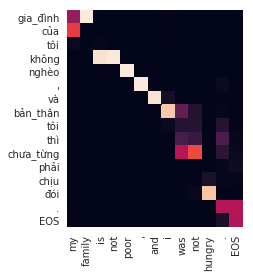

In [92]:
n = 5
draw(attention_scores[n],pred_corpus[n],src_corpus[n])